# Class Activation Mapping
This jupyter notebook implements the ideas of the paper https://arxiv.org/abs/1512.04150 which is from researches of MIT. The basic idea is, that a CNN learns activation maps as types of bounding boxes for free (without the need to label all bounding boxes by hand). 

<img src="architecture.png">

(Image copied from paper at  https://arxiv.org/abs/1512.04150)

## Steps to get the Class Activation Map (CAM)
(Prerequesite: CNN with Global Average Pooling layer after the last convolutional layer and NO additional dense layers (only the output dense layer for getting final predictions!)
1. Feed image to convolutional network and create perdiction
2. Fetch the weights connected to the winning neuron
3. Store the outputs from the last convolutional layer
4. Use the fetched weights to weight the corresponding output from last convolutional layer and add all values to one final map
5. Expand this final map (i.e. using bilinear upsampling) to the size of the input image and plot the results

## Dataset and Model
### Dataset
The used dataset can be found on Kaggel (https://www.kaggle.com/moltean/fruits). It's a dataset of 90483 images containing 131 different fruits and vegetables.

### Model
As model the pre-trained ResNet50 was downloaded from Keras and the last dense layers where dropped and a global average pooling layer was added (take a look into the Transfer_Learning.ipynb notebook from my github page). Then, a dense layer with as many neurons as classes in the dataset was added (131 neurons). The model was trained and tested using the data from the Kaggle dataset and finally stored as "my_model.h5".

In [1]:
# necessary imports
import os
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import scipy

%matplotlib inline

In [31]:
# format matplotlib
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

In [2]:
# check locally avaiable devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13584782987574202273
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2181393330057816746
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6619702240
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2903019014310055968
physical_device_desc: "device: 0, name: Quadro P4000, pci bus id: 0000:04:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14472724727734487228
physical_device_desc: "device: XLA_GPU device"
]


In [3]:
# store path to trained model
path = os.getcwd()
model_path = os.path.join(path, 'Trained_Model')

In [4]:
# set parameters of images such that they fit to ResNet-50 model which was used for training
img_width, img_height = 224, 224

test_data_dir = os.path.join(path, r'5857_1166105_bundle_archive\fruits-360\Test')

batch_size = 1000

In [5]:
# pre-process test data such that it has same pre-processing as data used for training
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 22688 images belonging to 131 classes.


In [6]:
def extract_labels(data_path):
    ''' this function returns a list of labels corresponding to the path provided '''
    return os.listdir(data_path)

def get_label(label_categorical, class_list):
    '''
    this fucntion returns the name of the label corresponding the the provided category 
    
    Inputs:
        1) : label_categorical (numpy array) : categorical array containing only a 1 for the selected label
        2) : class_list (list of strings) : list of strings containing the class names (extracted form the directory)
        
    Outputs:
        returns the string containing the correct class name
    '''
    # get index where label_categorical contains the 1
    index = np.where(label_categorical == 1)[0][0]
    # get label from class list using the index and return it
    return class_list[index]

In [7]:
# load pre-trained model
model_name = 'my_model.h5'
model_path_new = os.path.join(model_path, model_name)
loaded_model = tf.keras.models.load_model(model_path_new)

Size of image: (224, 224, 3)
Changed size of image: (1, 224, 224, 3)
Dates


Text(0.5, 1.0, 'Dates')

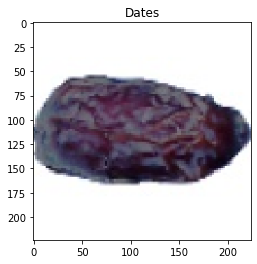

In [8]:
# make a prediction and check the result
batch_nr = 0
img_nr = np.random.choice(np.arange(0, batch_size))

# get list of class names
class_list = extract_labels(test_data_dir)

# get batch -> returns tuple (x, y) where x contains all the images of shape (batch_size, 224, 224, 3) and y contains the 
# corresonding labels of shape (batch_size, 131)
test_batch_tuple = test_generator[batch_nr]
test_batch_data = test_batch_tuple[0]

img = test_batch_data[img_nr]
print(f'Size of image: {img.shape}')

# expand dimension to fit the image to a network accepted input size
img = np.expand_dims(img, axis=0)
print(f'Changed size of image: {img.shape}')

# make prediction using the already trained model
predictions = loaded_model.predict(img)
label_index = np.argmax(predictions)
label_class_name = class_list[label_index]
print(label_class_name)

# show image and label
plt.imshow(np.squeeze(img))
plt.title(label_class_name)

In [9]:
def get_class_activation_map(model, img):
    ''' 
    this function computes the class activation map
    
    Inputs:
        1) model (tensorflow model) : trained model
        2) img (numpy array of shape (224, 224, 3)) : input image
    '''
    
    # expand dimension to fit the image to a network accepted input size
    img = np.expand_dims(img, axis=0)

    # predict to get the winning class
    predictions = model.predict(img)
    label_index = np.argmax(predictions)

    # Get the 2048 input weights to the softmax of the winning class.
    class_weights = model.layers[-1].get_weights()[0]
    class_weights_winner = class_weights[:, label_index]
    
    # get the final conv layer
    final_conv_layer = model.get_layer("conv5_block3_out")
    
    # create a function to fetch the final conv layer output maps (should be shape (1, 7, 7, 2048)) 
    get_output = K.function([model.layers[0].input],[final_conv_layer.output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img])
    
    # squeeze conv map to shape image to size (7, 7, 2048)
    conv_outputs = np.squeeze(conv_outputs)
    
    # bilinear upsampling to resize each filtered image to size of original image 
    mat_for_mult = scipy.ndimage.zoom(conv_outputs, (32, 32, 1), order=1) # dim: 224 x 224 x 2048

    # get class activation map for object class that is predicted to be in the image
    final_output = np.dot(mat_for_mult.reshape((224*224, 2048)), class_weights_winner).reshape(224,224) # dim: 224 x 224
    
    # return class activation map
    return final_output, label_index

In [26]:
def plot_class_activation_map(CAM, img, label, data_path, ax):
    ''' 
    this function plots the activation map 
    
    Inputs:
        1) CAM (numpy array of shape (224, 224)) : class activation map containing the trained heat map
        2) img (numpy array of shape (224, 224, 3)) : input image
        3) label (uint8) : index of the winning class
        4) data_path (string) : path to the images -> used to extract the class labels by extracting all local subdirs
        5) ax (matplotlib axes) : axes where current CAM should be plotted
    '''
    
    # plot image
    ax.imshow(img, alpha=0.5)
    
    # plot class activation map
    ax.imshow(CAM, cmap='jet', alpha=0.5)
    
    # get string for classified class
    class_list = extract_labels(data_path)
    class_label = class_list[label]
    ax.set_title(class_label)

In [27]:
def create_and_plot_6_CAMs(model, images, data_path, batch_size):
    '''
    this function creates and plots six class activation maps
    
    Inputs:
        1) model (tensorflow model) : trained model used for the prediction and conv outputs
        2) count_CAMs (uint8) : count of activation maps that shall be plotted
        3) images (numpy array of shape (batch_size, 224, 224, 3)) : array containing the images 
        4) data_path (string) : string containing the path to the images
        5) batch_size (uint8) : number of images 
    '''
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=True)
    
    # store axes in list for access in loop
    axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    
    # create random numbers for selecting the images
    img_nrs = np.random.choice(np.arange(0, batch_size), 6)
    
    # loop through the randomly selected image numbers and create plus plot CAM
    for index, img_index in enumerate(img_nrs):
        img = images[img_index]
        CAM, label = get_class_activation_map(model, img)
        plot_class_activation_map(CAM, img, label, data_path, axes[index])
        
    

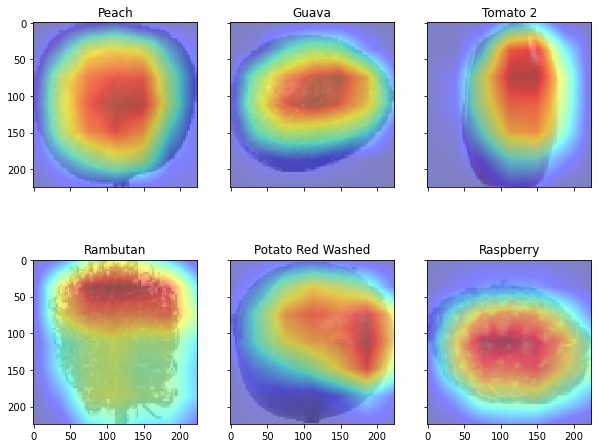

In [32]:
create_and_plot_6_CAMs(loaded_model, test_batch_data, test_data_dir, batch_size)